In [14]:
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt
import seaborn as sns

import imblearn

from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier, Pool
from catboost.utils import get_confusion_matrix

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
### download the db from link in readme
db_path = "../../dbs/delays_new.db"

In [3]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        connection.text_factory = str
    except Error as e:
        print("Error occurred: " + str(e))
    return connection


def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        if query == "":
            return "Query Blank"
        else:
            df = pd.read_sql_query(query, connection)
            return df
    except Error as e:
        return "Error occurred: " + str(e)

In [5]:
def evaluate_model(model, X_test, y_test):
    
    model_acc = model.score(X_test, y_test)
    print("Test Accuracy: {:.2f}%".format(model_acc * 100))
    
    y_true = np.array(y_test)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_true, y_pred)
    clr = classification_report(y_true, y_pred, target_names=["Not Delayed", "Delayed"])
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sp = tn / (tn+fp)
    sen = tp / (tp+fn)
    pr = tp / (tp+fp)
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.yticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)
    print("\n Specificity:", round(sp,2))
    print("\n Sensitivity:", round(sen,2))

In [6]:
sample_query = \
    """
        select 
         *
        from 
          delay
        where year = 2018
        order by RANDOM() LIMIT 100000
    """

connection = create_connection(db_path)
data =  execute_query(connection, sample_query)

In [7]:
data

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,...,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2018,2,6,12,2,2018-06-12,20363,9E,N8877A,5396,...,87,94,60,1,363,0,0,0,0,0
1,2018,4,11,17,6,2018-11-17,20368,G4,233NV,533,...,92,85,73,1,477,0,0,0,0,0
2,2018,3,9,13,4,2018-09-13,19977,UA,N68842,680,...,250,231,202,1,1846,0,0,0,0,0
3,2018,1,3,27,2,2018-03-27,19790,DL,N3763D,847,...,109,108,84,1,630,0,0,0,0,0
4,2018,4,11,17,6,2018-11-17,19805,AA,N917NN,2357,...,168,163,142,1,989,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2018,3,8,8,3,2018-08-08,19790,DL,N994DL,1270,...,84,66,46,1,271,0,0,0,0,0
99996,2018,1,1,7,7,2018-01-07,20452,YX,N810MD,5891,...,128,130,87,1,641,14,0,2,0,0
99997,2018,4,10,9,2,2018-10-09,20366,EV,N12564,4365,...,98,103,71,1,419,0,0,0,0,0
99998,2018,3,9,14,5,2018-09-14,20304,OO,N114SY,5802,...,131,140,106,1,751,0,0,0,0,0


## CatBoost Algorithm
### Standard Features
#### Without SMOTE

In [25]:
def preprocess_inputs_cat(df):
    df = df.copy()
    
    y = (df.ArrDelay>15).astype(int)
    
    df['IATA_CODE_Reporting_Airline'] = df['IATA_CODE_Reporting_Airline'].astype('category')
    df['IATA_CODE_Reporting_Airline'] = df['IATA_CODE_Reporting_Airline'].cat.codes
    
    df['OriginAirportID'] = df['OriginAirportID'].astype('category')
    df['OriginAirportID'] = df['OriginAirportID'].cat.codes
    
    df['DestAirportID'] = df['DestAirportID'].astype('category')
    df['DestAirportID'] = df['DestAirportID'].cat.codes
    
    df['Month'] = df['Month'].astype('category')
    df['Month'] = df['Month'].cat.codes
    
    X = df[['Month',
     'DayofMonth',
     'DayOfWeek',
     'IATA_CODE_Reporting_Airline',
     'OriginAirportID',
     'DestAirportID',
     'AirTime']]
    
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
   
    return X_train, X_test, y_train, y_test

In [26]:
X_train, X_test, y_train, y_test = preprocess_inputs_cat(data)

In [27]:
cat_features = list(range(0, X_train.shape[1]-1))
print(cat_features)

[0, 1, 2, 3, 4, 5]


In [28]:
clf = CatBoostClassifier(
    iterations=20, 
    learning_rate=0.1, 
    #loss_function='MultiClass'
)

clf.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 20, 'learning_rate': 0.1}


In [29]:
pool_train = Pool(X_train, y_train, 
        cat_features=cat_features)
get_confusion_matrix(clf, pool_train)

array([[65319.,     0.],
       [14681.,     0.]])

Test Accuracy: 81.95%


D:\Downloads\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Downloads\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Downloads\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-5-b1db52aa8b6c>:14: RuntimeWarning: invalid va

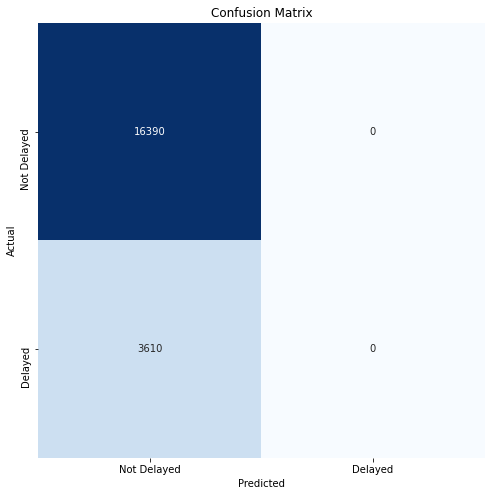

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.82      1.00      0.90     16390
     Delayed       0.00      0.00      0.00      3610

    accuracy                           0.82     20000
   macro avg       0.41      0.50      0.45     20000
weighted avg       0.67      0.82      0.74     20000


 Specificity: 1.0

 Sensitivity: 0.0


In [30]:
evaluate_model(clf, X_test, y_test)

#### With SMOTE

In [31]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [32]:
cat_features = list(range(0, X_train.shape[1]-1))
print(cat_features)

[0, 1, 2, 3, 4, 5]


In [33]:
clf = CatBoostClassifier(
    iterations=20, 
    learning_rate=0.1, 
    #loss_function='MultiClass'
)


clf.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 20, 'learning_rate': 0.1}


In [34]:
pool_train = Pool(X_train, y_train, 
        cat_features=cat_features)
get_confusion_matrix(clf, pool_train)

array([[49115., 16204.],
       [25033., 40286.]])

Test Accuracy: 67.44%


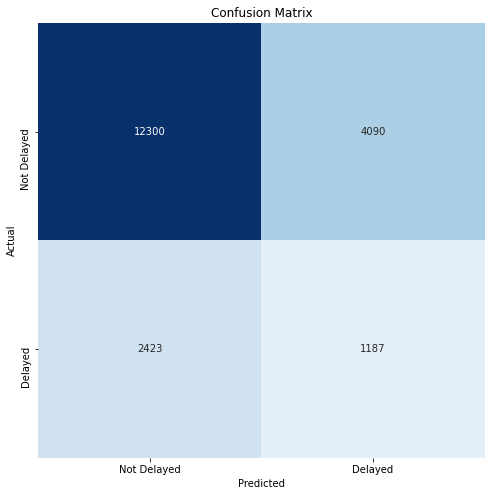

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.84      0.75      0.79     16390
     Delayed       0.22      0.33      0.27      3610

    accuracy                           0.67     20000
   macro avg       0.53      0.54      0.53     20000
weighted avg       0.73      0.67      0.70     20000


 Specificity: 0.75

 Sensitivity: 0.33


In [35]:
evaluate_model(clf, X_test, y_test)

### With Selected Features
#### Without SMOTE

In [36]:

def preprocess_inputs_cat_2(df):
    df = df.copy()
    
    y = (df.ArrDelayMinutes>15).astype(int)
    
    df['IATA_CODE_Reporting_Airline'] = df['IATA_CODE_Reporting_Airline'].astype('category')
    df['IATA_CODE_Reporting_Airline'] = df['IATA_CODE_Reporting_Airline'].cat.codes
    
    df['OriginAirportID'] = df['OriginAirportID'].astype('category')
    df['OriginAirportID'] = df['OriginAirportID'].cat.codes
    
    df['DestAirportID'] = df['DestAirportID'].astype('category')
    df['DestAirportID'] = df['DestAirportID'].cat.codes
    
    df['Month'] = df['Month'].astype('category')
    df['Month'] = df['Month'].cat.codes
    
    df['Tail_Number'] = df['Tail_Number'].astype('category')
    df['Tail_Number'] = df['Tail_Number'].cat.codes
    
    df['Flight_Number_Reporting_Airline'] = df['Flight_Number_Reporting_Airline'].astype('category')
    df['Flight_Number_Reporting_Airline'] = df['Flight_Number_Reporting_Airline'].cat.codes
    
    
    X = df[['Month',
     'IATA_CODE_Reporting_Airline',
     'OriginAirportID',
     'DestAirportID',
     'Tail_Number',
     'Flight_Number_Reporting_Airline',
     'DayofMonth',
     'DayOfWeek',
     'AirTime']]
    

    
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    
    
    return X_train, X_test, y_train, y_test

In [37]:
X_train, X_test, y_train, y_test = preprocess_inputs_cat_2(data)

In [38]:
cat_features = list(range(0, X_train.shape[1]-1))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7]


In [39]:
clf = CatBoostClassifier(
    iterations=20, 
    learning_rate=0.1, 
    #loss_function='MultiClass'
)

clf.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 20, 'learning_rate': 0.1}


In [40]:
pool_train = Pool(X_train, y_train, 
        cat_features=cat_features)
get_confusion_matrix(clf, pool_train)

array([[65319.,     0.],
       [14681.,     0.]])

Test Accuracy: 81.95%


D:\Downloads\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Downloads\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Downloads\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-5-b1db52aa8b6c>:14: RuntimeWarning: invalid va

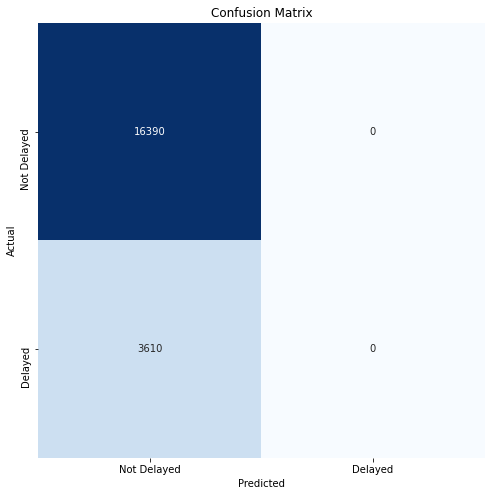

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.82      1.00      0.90     16390
     Delayed       0.00      0.00      0.00      3610

    accuracy                           0.82     20000
   macro avg       0.41      0.50      0.45     20000
weighted avg       0.67      0.82      0.74     20000


 Specificity: 1.0

 Sensitivity: 0.0


In [41]:
evaluate_model(clf, X_test, y_test)

#### With SMOTE

In [42]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [43]:
cat_features = list(range(0, X_train.shape[1]-1))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7]


In [44]:
clf = CatBoostClassifier(
    iterations=20, 
    learning_rate=0.1, 
    #loss_function='MultiClass'
)

clf.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 20, 'learning_rate': 0.1}


In [45]:
# from catboost.utils import get_confusion_matrix
pool_train = Pool(X_train, y_train, 
        cat_features=cat_features)
get_confusion_matrix(clf, pool_train)

array([[59201.,  6118.],
       [22169., 43150.]])

Test Accuracy: 75.89%


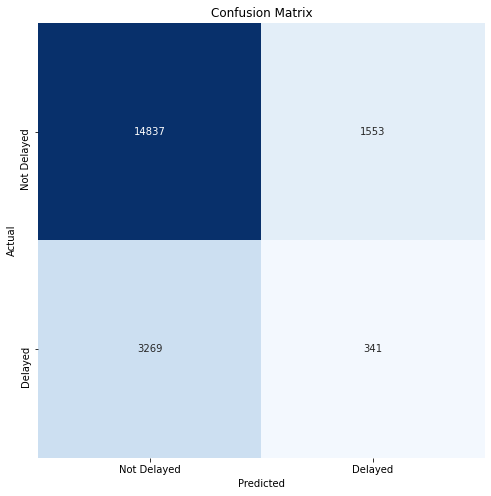

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.82      0.91      0.86     16390
     Delayed       0.18      0.09      0.12      3610

    accuracy                           0.76     20000
   macro avg       0.50      0.50      0.49     20000
weighted avg       0.70      0.76      0.73     20000


 Specificity: 0.91

 Sensitivity: 0.09


In [46]:
evaluate_model(clf, X_test, y_test)

### Dropping Tail Number

#### Without SMOTE

In [62]:
def preprocess_inputs_cat_3(df):
    df = df.copy()
    
    y = (df.ArrDelayMinutes>15).astype(int)
    
    df['IATA_CODE_Reporting_Airline'] = df['IATA_CODE_Reporting_Airline'].astype('category')
    df['IATA_CODE_Reporting_Airline'] = df['IATA_CODE_Reporting_Airline'].cat.codes
    
    df['OriginAirportID'] = df['OriginAirportID'].astype('category')
    df['OriginAirportID'] = df['OriginAirportID'].cat.codes
    
    df['DestAirportID'] = df['DestAirportID'].astype('category')
    df['DestAirportID'] = df['DestAirportID'].cat.codes
    
    df['Month'] = df['Month'].astype('category')
    df['Month'] = df['Month'].cat.codes
    
    df['Flight_Number_Reporting_Airline'] = df['Flight_Number_Reporting_Airline'].astype('category')
    df['Flight_Number_Reporting_Airline'] = df['Flight_Number_Reporting_Airline'].cat.codes
    
    
    X = df[['Month',
     'DayofMonth',
     'DayOfWeek',
     'IATA_CODE_Reporting_Airline',
     'OriginAirportID',
     'DestAirportID',
     'Flight_Number_Reporting_Airline',
     'AirTime']]
    

    
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    
    
    return X_train, X_test, y_train, y_test

In [63]:
X_train, X_test, y_train, y_test = preprocess_inputs_cat_3(data)

In [64]:
cat_features = list(range(0, X_train.shape[1]-1))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6]


In [65]:
clf = CatBoostClassifier(
    iterations=20, 
    learning_rate=0.1, 
    #loss_function='MultiClass'
)

clf.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 20, 'learning_rate': 0.1}


In [66]:
pool_train = Pool(X_train, y_train, 
        cat_features=cat_features)
get_confusion_matrix(clf, pool_train)

array([[65319.,     0.],
       [14681.,     0.]])

Test Accuracy: 81.95%


D:\Downloads\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Downloads\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Downloads\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-5-b1db52aa8b6c>:14: RuntimeWarning: invalid va

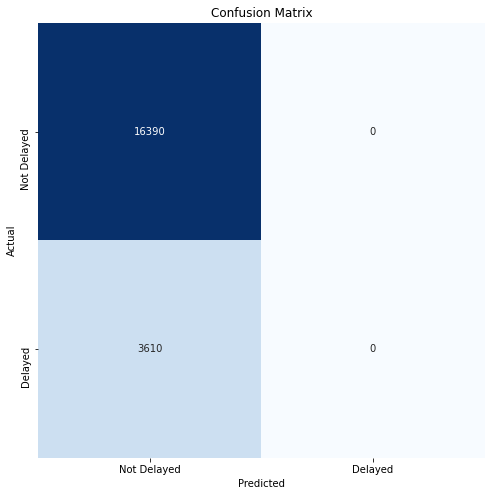

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.82      1.00      0.90     16390
     Delayed       0.00      0.00      0.00      3610

    accuracy                           0.82     20000
   macro avg       0.41      0.50      0.45     20000
weighted avg       0.67      0.82      0.74     20000


 Specificity: 1.0

 Sensitivity: 0.0


In [67]:
evaluate_model(clf, X_test, y_test)

#### With SMOTE

In [68]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [69]:
cat_features = list(range(0, X_train.shape[1]-1))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6]


In [70]:
clf = CatBoostClassifier(
    iterations=20, 
    learning_rate=0.1, 
    #loss_function='MultiClass'
)

clf.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 20, 'learning_rate': 0.1}


In [71]:
pool_train = Pool(X_train, y_train, 
        cat_features=cat_features)
get_confusion_matrix(clf, pool_train)

array([[57191.,  8128.],
       [24292., 41027.]])

Test Accuracy: 74.36%


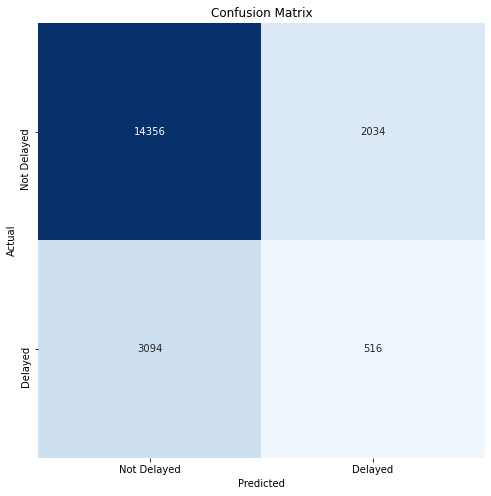

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.82      0.88      0.85     16390
     Delayed       0.20      0.14      0.17      3610

    accuracy                           0.74     20000
   macro avg       0.51      0.51      0.51     20000
weighted avg       0.71      0.74      0.73     20000


 Specificity: 0.88

 Sensitivity: 0.14


In [72]:
evaluate_model(clf, X_test, y_test)

### With Departure Delay
#### Without SMOTE

In [73]:
def preprocess_inputs_cat_4(df):
    df = df.copy()
    
    y = (df.ArrDelay>15).astype(int)
    
    df['IATA_CODE_Reporting_Airline'] = df['IATA_CODE_Reporting_Airline'].astype('category')
    df['IATA_CODE_Reporting_Airline'] = df['IATA_CODE_Reporting_Airline'].cat.codes
    
    df['OriginAirportID'] = df['OriginAirportID'].astype('category')
    df['OriginAirportID'] = df['OriginAirportID'].cat.codes
    
    df['DestAirportID'] = df['DestAirportID'].astype('category')
    df['DestAirportID'] = df['DestAirportID'].cat.codes
    
    df['Month'] = df['Month'].astype('category')
    df['Month'] = df['Month'].cat.codes
    
    X = df[['Month',
     'DayofMonth',
     'DayOfWeek',
     'IATA_CODE_Reporting_Airline',
     'OriginAirportID',
     'DestAirportID',
     'AirTime',
     'DepDelay']]
    
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    
   
    return X_train, X_test, y_train, y_test

In [74]:
X_train, X_test, y_train, y_test = preprocess_inputs_cat_4(data)

In [75]:
cat_features = list(range(0, X_train.shape[1]-2))
print(cat_features)

[0, 1, 2, 3, 4, 5]


In [76]:
clf = CatBoostClassifier(
    iterations=20, 
    learning_rate=0.1, 
    #loss_function='MultiClass'
)

clf.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 20, 'learning_rate': 0.1}


In [77]:
pool_train = Pool(X_train, y_train, 
        cat_features=cat_features)
get_confusion_matrix(clf, pool_train)

array([[64091.,  1228.],
       [ 4098., 10583.]])

Test Accuracy: 93.48%


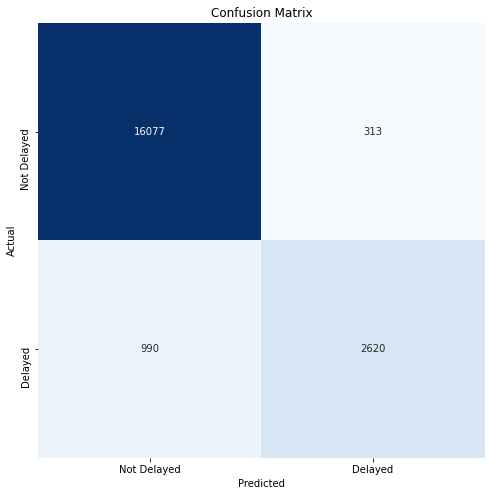

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.94      0.98      0.96     16390
     Delayed       0.89      0.73      0.80      3610

    accuracy                           0.93     20000
   macro avg       0.92      0.85      0.88     20000
weighted avg       0.93      0.93      0.93     20000


 Specificity: 0.98

 Sensitivity: 0.73


In [78]:
evaluate_model(clf, X_test, y_test)

#### With SMOTE

In [79]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [80]:
cat_features = list(range(0, X_train.shape[1]-2))
print(cat_features)

[0, 1, 2, 3, 4, 5]


In [81]:
clf = CatBoostClassifier(
    iterations=20, 
    learning_rate=0.1, 
    #loss_function='MultiClass'
)

clf.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 20, 'learning_rate': 0.1}


In [82]:
pool_train = Pool(X_train, y_train, 
        cat_features=cat_features)
get_confusion_matrix(clf, pool_train)

array([[61027.,  4292.],
       [10957., 54362.]])

Test Accuracy: 91.19%


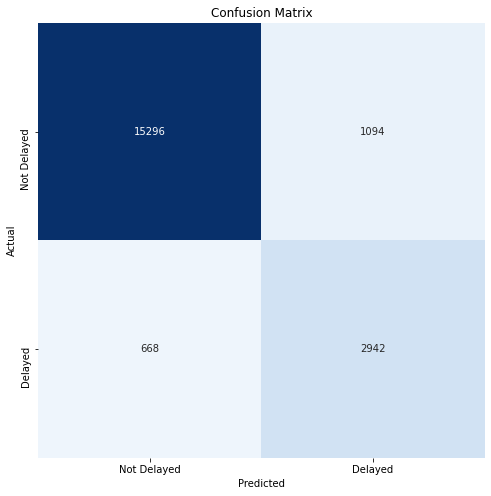

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.96      0.93      0.95     16390
     Delayed       0.73      0.81      0.77      3610

    accuracy                           0.91     20000
   macro avg       0.84      0.87      0.86     20000
weighted avg       0.92      0.91      0.91     20000


 Specificity: 0.93

 Sensitivity: 0.81


In [83]:
evaluate_model(clf, X_test, y_test)